Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 36,433,537
Trainable params: 12,845,569
Non-trainable params: 23,587,968
_________________________________________________________________
Epoch 1/15
52/52 [==============================] - 10s 192ms/step - loss: 0.0355 - accuracy: 0.9823 

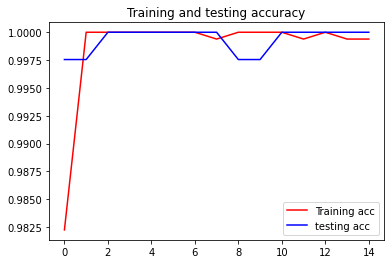

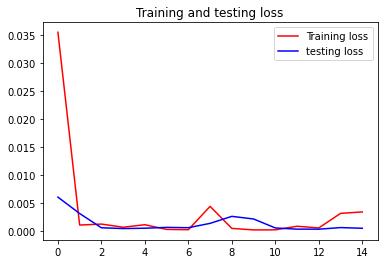

Saved model to disk


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt

path_dir1 = './a1/'
path_dir2 = './a2/'

file_list1 = os.listdir(path_dir1)  # path에 존재하는 파일 목록 가져오기
file_list2 = os.listdir(path_dir2)

file_list1_num = len(file_list1)
file_list2_num = len(file_list2)

file_num = file_list1_num + file_list2_num

# %% 이미지 전처리
num = 0;
all_img = np.float32(np.zeros((file_num, 224, 224, 3)))
all_label = np.float64(np.zeros((file_num, 1)))

for img_name in file_list1:
    img_path = path_dir1 + img_name
    img = load_img(img_path, target_size=(224, 224))

    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    all_img[num, :, :, :] = x

    all_label[num] = 0  # nomask
    num = num + 1

for img_name in file_list2:
    img_path = path_dir2 + img_name
    img = load_img(img_path, target_size=(224, 224))

    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    all_img[num, :, :, :] = x

    all_label[num] = 1  # mask
    num = num + 1

# 데이터셋 섞기(적절하게 훈련되게 하기 위함)
n_elem = all_label.shape[0]
indices = np.random.choice(n_elem, size=n_elem, replace=False)

all_label = all_label[indices]
all_img = all_img[indices]

# 훈련셋 테스트셋 분할
num_train = int(np.round(all_label.shape[0] * 0.8))
num_test = int(np.round(all_label.shape[0] * 0.2))

train_img = all_img[0:num_train, :, :, :]
test_img = all_img[num_train:, :, :, :]

train_label = all_label[0:num_train]
test_label = all_label[num_train:]

# %%
# create the base pre-trained model
IMG_SHAPE = (224, 224, 3)

base_model = ResNet50(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False
base_model.summary()
print("Number of layers in the base model: ", len(base_model.layers))

flatten_layer = Flatten()
dense_layer1 = Dense(128, activation='relu')
bn_layer1 = BatchNormalization()
dense_layer2 = Dense(1, activation=tf.nn.sigmoid)

model = Sequential([
    base_model,
    flatten_layer,
    dense_layer1,
    bn_layer1,
    dense_layer2,
])

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(train_img, train_label, epochs=15, batch_size=32, validation_data=(test_img, test_label))

# save model
model.save("stage12.h5")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))



plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()

plt.show()

print("Saved model to disk")